## Семинар 10: "Генерация текстов"

ФИО: Шпитальник Александр Сергеевич

In [36]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
import tqdm
# import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [37]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

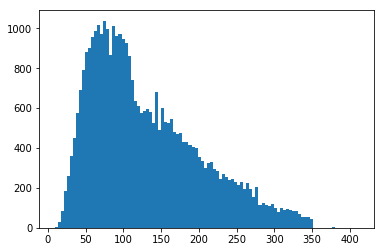

In [38]:
plt.hist(list(map(len, lines)), bins=100);

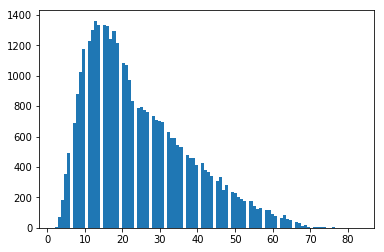

In [39]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [40]:
line = lines[0]

In [41]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [42]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [43]:
np.random.seed(777)
torch.random.manual_seed(777)

In [44]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [45]:
vocab = Vocabulary(lines)

In [46]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [47]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [48]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [49]:
dataset = Quotes(lines, vocab)

In [28]:
train_size = int(len(dataset)*0.9)
test_size = len(dataset) - train_size

In [15]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [16]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output) ##f!!!!
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [17]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [18]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [20]:
losses = []

In [64]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

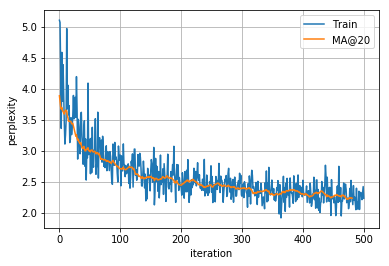

 94%|█████████▎| 502/536 [05:14<00:21,  1.60it/s]

In [ ]:
for epoch in range(1000):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [ ]:
oracle.generate(vocab)

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [ ]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [50]:
train_size = int(len(dataset)*0.9)
test_size = len(dataset) - train_size

In [51]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [52]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

In [85]:
class LSTM_Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(LSTM_Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output) ##f!!!!
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        c = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, requires_grad=False)
            embedding = self.embedding(token_id)
            output, (h, c) = self.generator(embedding, (h, c))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [86]:
oracle = LSTM_Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

In [87]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [88]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [89]:
train_losses_epochs = []
test_losses_epochs = []

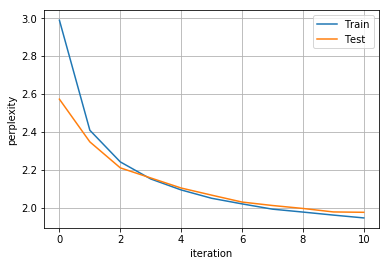

In [92]:
for epoch in range(10):
    tmp_train =[]
    tmp_test = []
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train_loader, total=len(train_loader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        tmp_train.append(np.exp(loss.item()))
    train_losses_epochs.append(np.mean(tmp_train))
        
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test_loader, total=len(test_loader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        tmp_test.append(np.exp(loss.item()))
    test_losses_epochs.append(np.mean(tmp_test))
    
    clear_output(True)
    plt.plot(train_losses_epochs, label='Train')
    plt.plot(test_losses_epochs, label='Test')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()
            
            
            

In [93]:
oracle.generate(vocab)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


"I don'chpet I feel thought a way lixtisk is solm jostimities like a startezs befence and our compain"

In [104]:
new_oracle = LSTM_Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=3)

In [105]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [106]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [107]:
train_losses_epochs = []
test_losses_epochs = []

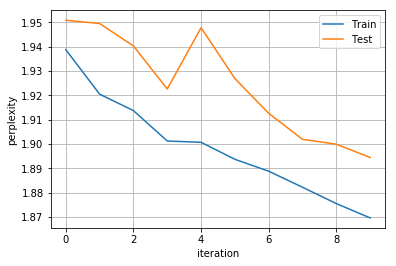

In [108]:
for epoch in range(10):
    tmp_train =[]
    tmp_test = []
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train_loader, total=len(train_loader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        tmp_train.append(np.exp(loss.item()))
    train_losses_epochs.append(np.mean(tmp_train))
        
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test_loader, total=len(test_loader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        tmp_test.append(np.exp(loss.item()))
    test_losses_epochs.append(np.mean(tmp_test))
        
        
    clear_output(True)
    plt.plot(train_losses_epochs, label='Train')
    plt.plot(test_losses_epochs, label='Test')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()
            
            
            

In [111]:
oracle.generate(vocab)

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'If you want to do, what consisom really work right poses with the courect and where try to wear exer'

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: